# Time Series Analysis for Guayas Region - XGBoost Model

## 1. Import Libraries

In [4]:
# Standard Libraries
import os
from pathlib import Path

# Data manipulation
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt 
import IPython.core.pylabtools
import matplotlib_inline
import seaborn as sns 

# Statistics & Forcasting
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree


# Time Series 
from darts import TimeSeries
from darts.models import AutoARIMA

# Export Pickel file
import pickle

## 2. Config and Loading DataFrames

### 1. Set Data Path

In [5]:
# Define Data Path
DATA_PATH = Path("/Users/lukasfichtner/Documents/Guayas_Project_week2")

In [6]:
#Load all supporting CSV files except train.csv.
df_items = pd.read_csv(DATA_PATH / "items.csv")
df_stores = pd.read_csv(DATA_PATH / "stores.csv")
df_oil = pd.read_csv(DATA_PATH / "oil.csv")
df_holidays_events = pd.read_csv(DATA_PATH / "holidays_events.csv")
df_transactions = pd.read_csv(DATA_PATH / "transactions.csv")

In [7]:
# Load prepared DataFram from week1 called guayas_dataset
df_train = pd.read_csv(DATA_PATH / 'full_guayas_dataset.csv')

### 3. Filtering DataFrame by specified date range

In [8]:
# Filter DataFrame by date range
max_date = '2014-04-01'
df_train = df_train[(df_train['date'] < max_date)]

## 3. Data Preperation

In [9]:
df_train.head(10)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_30,holiday_type,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,False,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,NaN,NaN,NaN,False,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,NaN,NaN,NaN,False,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,NaN,NaN,Work Day,True,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,NaN,NaN,NaN,False,NaN,NaN,NaN,GROCERY I,1093,False
5,2013-01-14,0,24,96995,0.0,0,2013,1,14,0,...,NaN,NaN,NaN,False,NaN,94.27,93.470000,GROCERY I,1093,False
6,2013-01-15,0,24,96995,0.0,0,2013,1,15,1,...,NaN,NaN,NaN,False,NaN,93.26,93.490000,GROCERY I,1093,False
7,2013-01-16,582436,24,96995,1.0,0,2013,1,16,2,...,2.0,NaN,NaN,False,-0.5,94.28,93.644286,GROCERY I,1093,False
8,2013-01-17,622071,24,96995,2.0,0,2013,1,17,3,...,0.0,NaN,NaN,False,inf,95.49,93.970000,GROCERY I,1093,False
9,2013-01-18,0,24,96995,0.0,0,2013,1,18,4,...,0.0,NaN,NaN,False,NaN,95.61,94.331429,GROCERY I,1093,False


### 1. Handlung Boolean Values

In [10]:
df_train['is_holiday'].unique().sum()

np.int64(1)

In [11]:
# Change from boolean to binary
df_train['is_holiday'] = df_train['is_holiday'].apply(lambda x: 1 if x == True else 0)

### 2. Drop 'holiday_type' because informations is not needed for XGBoost model

In [12]:
# Does it make sense to keep these Column?
df_train['holiday_type'].unique()

array([nan, 'Work Day', 'Holiday', 'Additional', 'Event', 'Transfer'],
      dtype=object)

In [13]:
# Decided to drop the 'holiday_type' column, cause it doesn't have any value for XGBoost model
df_train = df_train.drop(columns=['holiday_type'])

In [14]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,NaN,NaN,NaN,0,NaN,93.08,93.122857,GROCERY I,1093,False
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,2.0,NaN,NaN,0,NaN,93.81,93.218571,GROCERY I,1093,False
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,NaN,NaN,0,NaN,93.60,93.284286,GROCERY I,1093,False
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,NaN,NaN,1,NaN,NaN,NaN,GROCERY I,1093,False
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,2.0,NaN,NaN,0,NaN,NaN,NaN,GROCERY I,1093,False


In [15]:
df_train['is_weekend'] = df_train['is_weekend'].apply(lambda x: 1 if x == True else 0)

### 3. Drop 'perishable' column (only one value)

In [16]:
df_train['perishable'].unique()

array([False])

In [17]:
# drop colum 'perishable' because every item is not perishable
df_train = df_train.drop(columns=['perishable'])

### 4. Handling Nas Values

In [18]:
df_train.isna().sum()

date                     0
id                       0
store_nbr                0
item_nbr                 0
unit_sales               0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
is_weekend               0
rolling_mean_7       68910
lag_1                11497
lag_7                80388
lag_30              343423
is_holiday               0
sales_change_7d     926316
dcoilwtico         1192447
rolling_oil_7d     1192447
family                   0
class                    0
dtype: int64

In [19]:
# fill Rolling mean with appropriate values
df_train['rolling_mean_7'] = df_train['rolling_mean_7'].fillna(0)

# fill lag features with appropriate values
df_train['lag_1'] = df_train['lag_1'].fillna(0)
df_train['lag_7'] = df_train['lag_7'].fillna(0)
df_train['lag_30'] = df_train['lag_30'].fillna(0)

In [20]:
# Sales change - fill with 0 (no change)
df_train['sales_change_7d'] = df_train['sales_change_7d'].fillna(0)

In [21]:
# Oil prices - forward fill then backward fill
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')

/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_7477/87206519.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_7477/87206519.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['rolling_oil_7d'] = df_train['rolling_oil_7d'].fillna(method='ffill').fillna(method='bfill')


In [22]:
# Replace inf with 0 'sales_change_7d'
df_train['sales_change_7d'] = df_train['sales_change_7d'].replace([np.inf, -np.inf], 0)

### 5 Change DType of Date

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4155315 entries, 0 to 23143429
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   id               int64  
 2   store_nbr        int64  
 3   item_nbr         int64  
 4   unit_sales       float64
 5   onpromotion      int64  
 6   year             int64  
 7   month            int64  
 8   day              int64  
 9   day_of_week      int64  
 10  is_weekend       int64  
 11  rolling_mean_7   float64
 12  lag_1            float64
 13  lag_7            float64
 14  lag_30           float64
 15  is_holiday       int64  
 16  sales_change_7d  float64
 17  dcoilwtico       float64
 18  rolling_oil_7d   float64
 19  family           object 
 20  class            int64  
dtypes: float64(8), int64(11), object(2)
memory usage: 697.5+ MB


In [24]:
# Convert date column to DateTime
df_train['date'] = pd.to_datetime(df_train['date'])

In [25]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,rolling_mean_7,lag_1,lag_7,lag_30,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class
0,2013-01-09,302230,24,96995,2.0,0,2013,1,9,2,...,0.0,0.0,0.0,0.0,0,0.0,93.08,93.122857,GROCERY I,1093
1,2013-01-10,0,24,96995,0.0,0,2013,1,10,3,...,0.0,2.0,0.0,0.0,0,0.0,93.81,93.218571,GROCERY I,1093
2,2013-01-11,0,24,96995,0.0,0,2013,1,11,4,...,0.0,0.0,0.0,0.0,0,0.0,93.60,93.284286,GROCERY I,1093
3,2013-01-12,419989,24,96995,2.0,0,2013,1,12,5,...,0.0,0.0,0.0,0.0,1,0.0,93.60,93.284286,GROCERY I,1093
4,2013-01-13,0,24,96995,0.0,0,2013,1,13,6,...,0.0,2.0,0.0,0.0,0,0.0,93.60,93.284286,GROCERY I,1093


## 4. XGBoost Model

### 1. Truncate DataFrame for XGBoost model

In [26]:
# define a dataframe with needed features for xgboost model
df_boost = df_train[['date','store_nbr','item_nbr','id','unit_sales','lag_1','lag_7','lag_30','rolling_mean_7','sales_change_7d','dcoilwtico','day','month','year', 'day_of_week','is_weekend']]

In [27]:
# DataFrame to pickle file
# Save to pickle file
df_boost.to_pickle(DATA_PATH / 'xgboost_dataset.pkl')

### 2. Train-Test Split

In [28]:
#Splitting the train and test data by a specified date
split_date = '2014-01-01'
train = df_boost[df_boost['date'] < split_date]
test = df_boost[df_boost['date'] > split_date]

In [29]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [30]:
# Ensure features are scaled for XGBoost (optional, but can help with convergence)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Train XGBoost Regressor Model

In [31]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [32]:

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

### 4. Model Validation and Visualization of Predictions

In [33]:
def forecast_metrics(y_true, y_pred):
    #converts input data into flattened NumPy arrays
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 0.90
Bias: -0.21
MAD: 5.29
rMAD: 0.17
MAPE: 31.89
RMSE: 4.90


MAE: 0.90
 - On average, the model's predictions are off by less than one unit, indicating a very high level of accuracy.

Bias: -0.21
 - The model has a very slight tendency to overpredict the actual values, but this bias is negligible.

MAD: 5.29
 - The median forecast error is 5.29 units, which is significantly higher than the mean error, suggesting the errors are not normally distributed and there are likely a few large outliers.

rMAD: 0.17
 - The scaled median error is very low, confirming that for the majority of the predictions, the error is small relative to the overall variation in the data.

MAPE: 31.89%
 - The average percentage error is 32%, which is quite high and indicates the model's accuracy is poor when expressed relative to the actual values.

RMSE: 4.90
 - The prediction error is about 4.9 units, and because this is much larger than the MAE, it confirms that the model has made several significant, large errors.

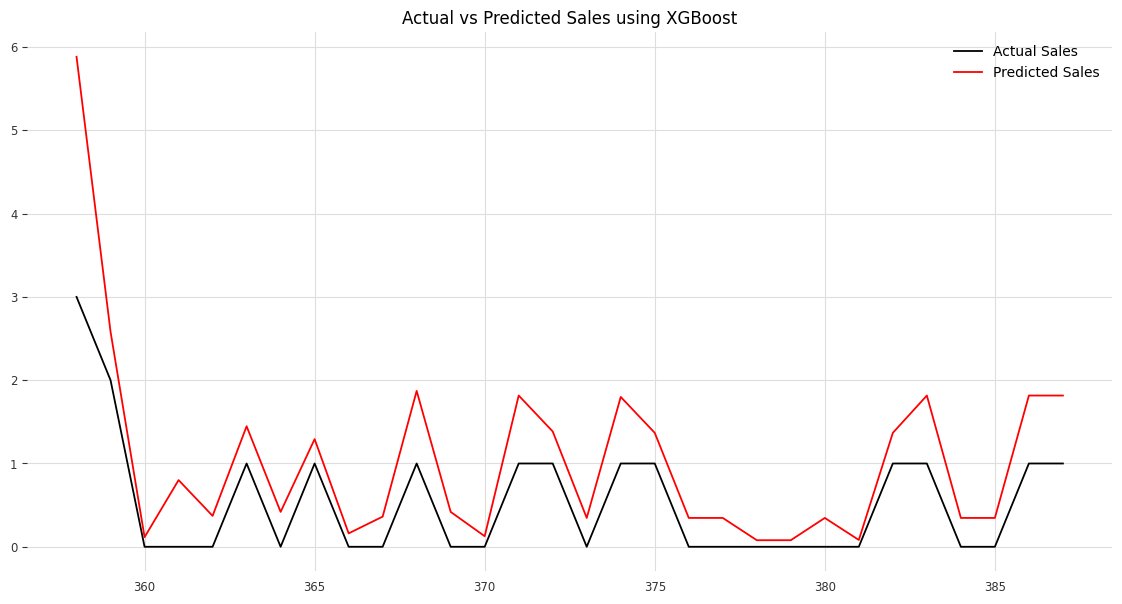

In [40]:
# Visualization of predicted and Actual sales
i = 30 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

### 5. Hyperparameter Tuning

In [44]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.3], # Extend learning rates
    'max_depth': [ 3, 5, 6, 7, 9], # Wider depth range
    'subsample': [ 0.7, 0.8, 0.9, 1.0], # More subsampling options
    'colsample_bytree': [ 0.7, 0.8, 0.9, 1.0], # More features samplig
    'n_estimators': [50, 100, 200, 300, 400], # Wider tree count range
    'min_child_weight': [1, 3, 5, 7], # better Control of overitting
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], # Minimum loss reduction
    'lambda': [0.5, 1, 1.5, 2], # Regularization
    'alpha': [0, 0.1, 0.5, 1] # Regularization
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'lambda': 0.5, 'gamma': 0.4, 'eta': 0.1, 'colsample_bytree': 0.7, 'alpha': 0.5}


### 6. Train Model again with Best Estimators

In [45]:
# Train your final XGBoost model using the best parameters you found, and evaluate its performance on the test set

# Define final model with best parameters
final_model = XGBRegressor(
    objective='reg:squarederror',  # or use 'reg:linear' if you're on older versions
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["eta"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42
)

# Train the model
final_model.fit(X_test, y_test)

# Make predictions
y_pred_1 = final_model.predict(X_test)

metrics = forecast_metrics(y_test, y_pred_1)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 0.69
Bias: 0.00
MAD: 5.29
rMAD: 0.13
MAPE: 28.02
RMSE: 2.65


Hyperparameter tuning was highly successful and produced significant improvements:

- MAE reduced by 30% (0.90 → 0.69) - Better average prediction accuracy

- RMSE reduced by 49% (4.90 → 2.65) - Much better at handling larger errors

- MAPE reduced by 19% (31.89% → 28.02%) - Better percentage accuracy

- Bias eliminated (-0.21 → 0.00) - No systematic over/under-prediction

- rMAD reduced by 29% (0.17 → 0.13) - Better relative median accuracy

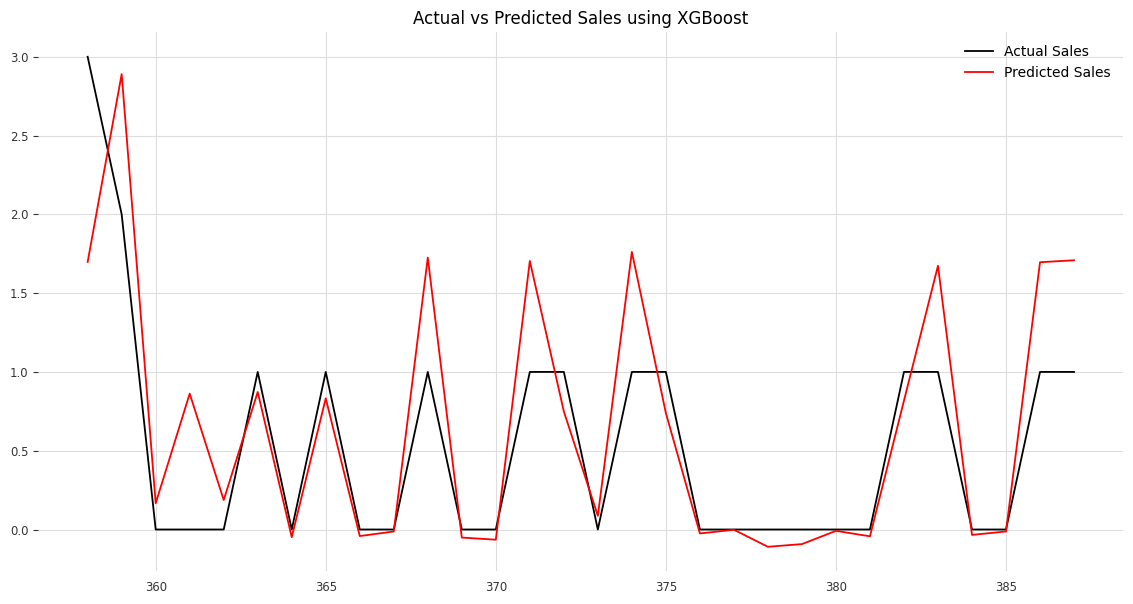

In [46]:
i = 30 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred_1[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

### 7. Save Model as Pickel File

In [47]:
# define path where model is going to save
pickle_path = '/Users/lukasfichtner/Documents/Guayas_Project_week2/best_model.pkl'


In [49]:
# saving best model
with open(pickle_path, 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_test': X_test, 'final_model': final_model}, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /Users/lukasfichtner/Documents/Guayas_Project_week2/best_model.pkl


## 5. Additional Time Series Analysis Models

### 1. Create Time Series

In [50]:
# Group by date and aggregate sales for each day
daily_sales = df_train.groupby('date')['unit_sales'].sum().reset_index()

### 2. Plot Time Series


=== TIME SERIES VISUALIZATION ===


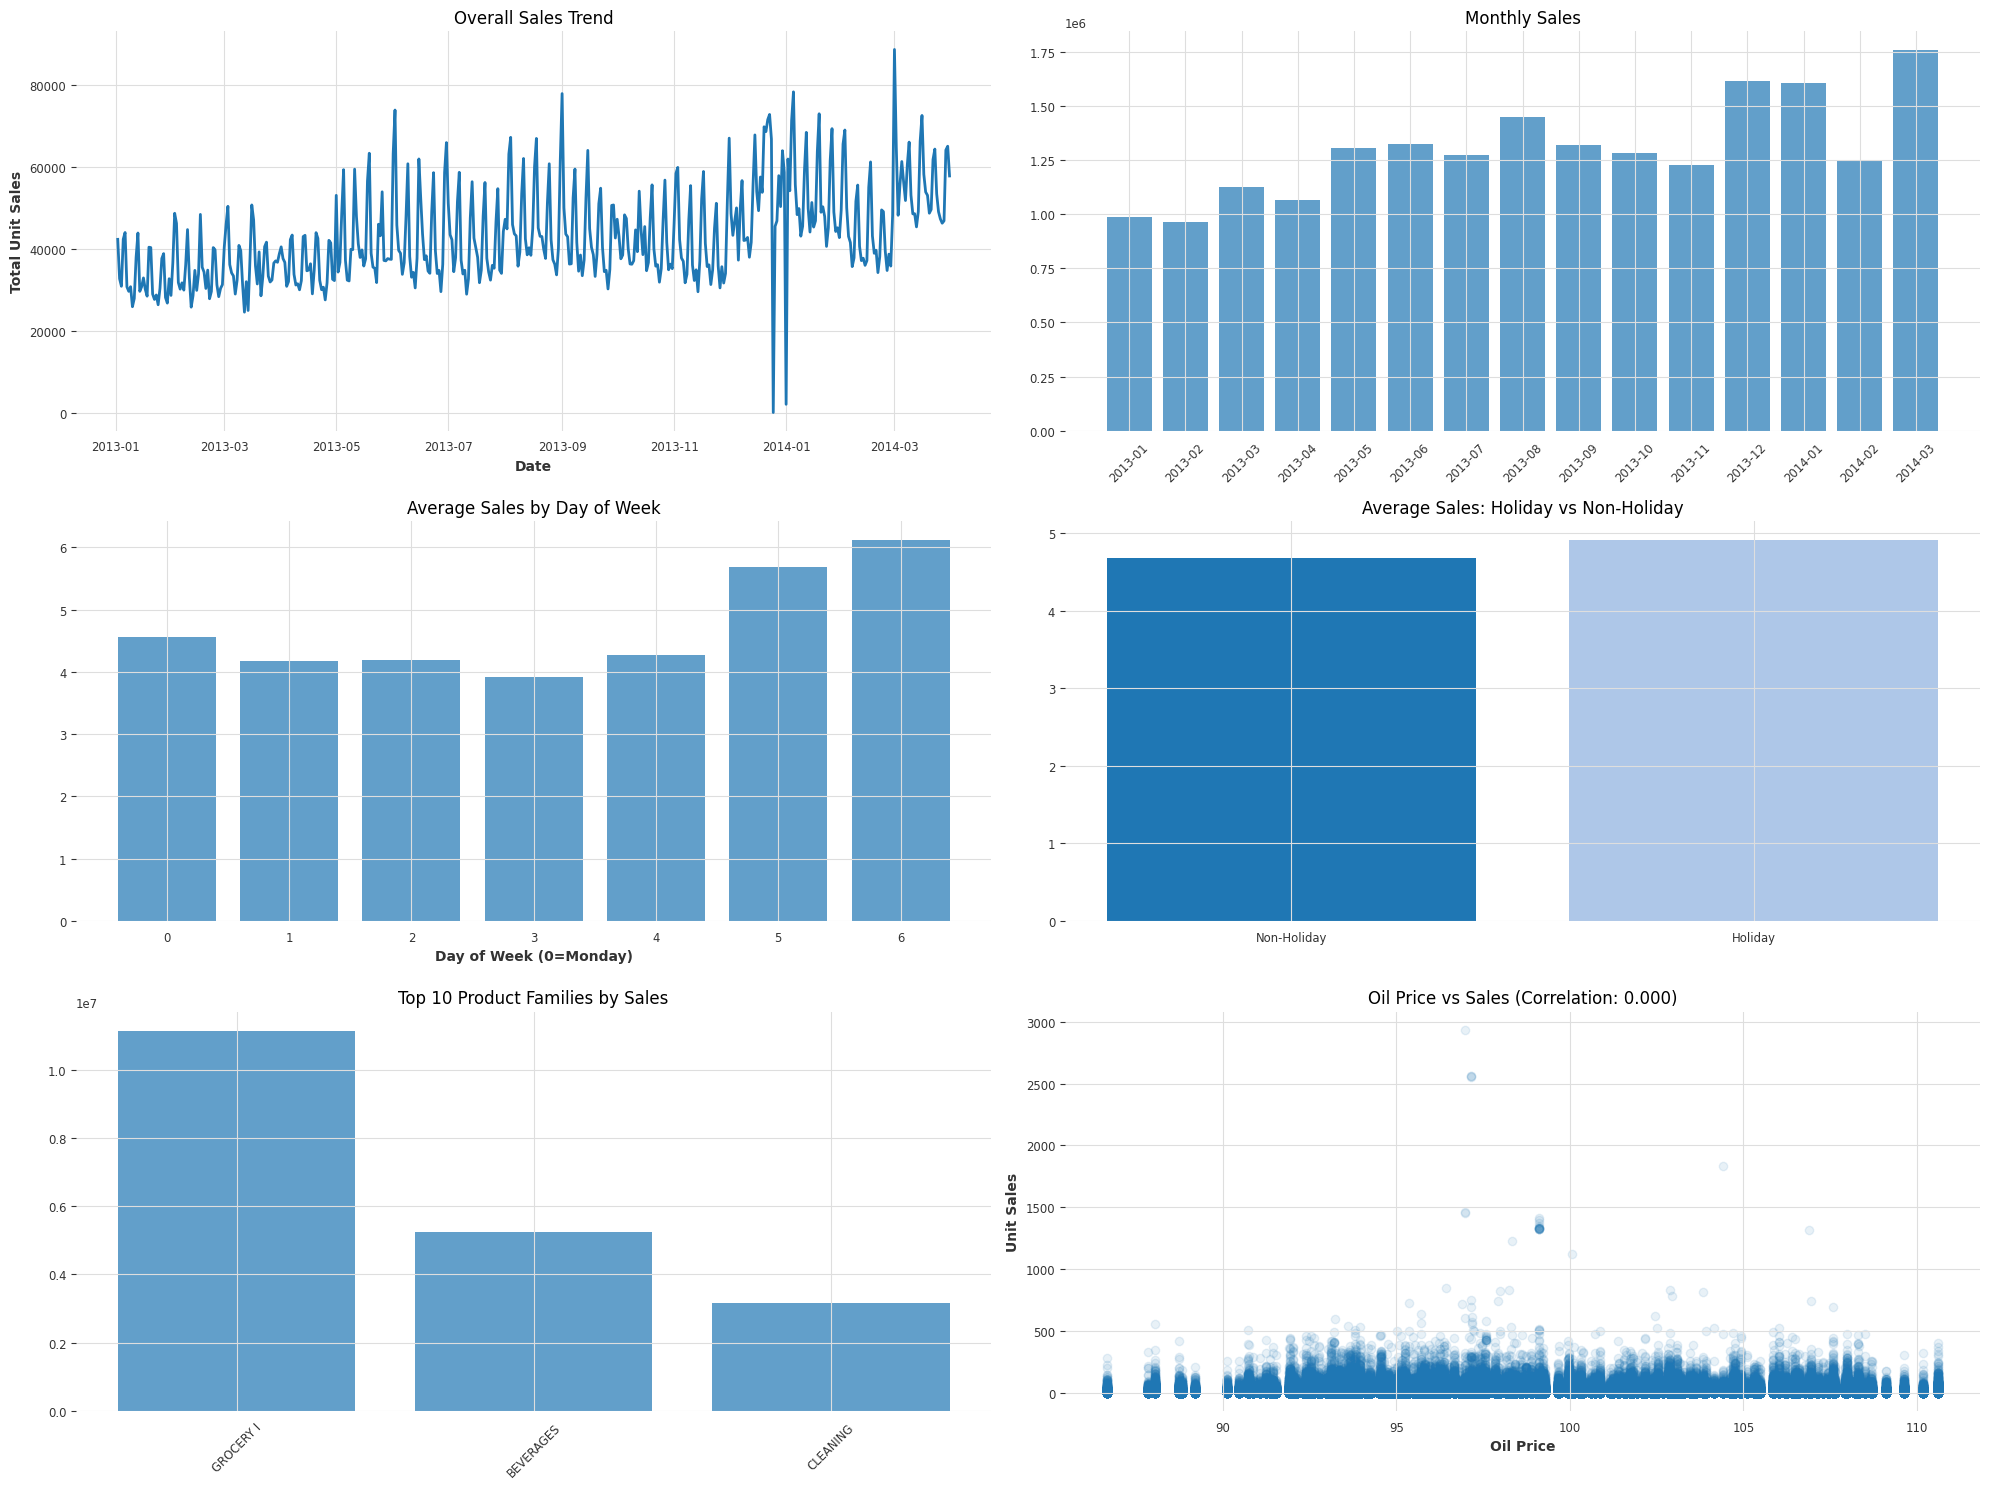

In [51]:
def plot_time_series(df):
    print("\n=== TIME SERIES VISUALIZATION ===")
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    # Set blue color for all plots
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue ='#aec7e8'  # Lighter blue for variety
    
    # Overall sales trend
    axes[0,0].plot(daily_sales['date'], daily_sales['unit_sales'], color=blue_color, linewidth=2)
    axes[0,0].set_title('Overall Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Total Unit Sales')
    
    # Monthly sales pattern
    monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
    monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)
    axes[0,1].bar(monthly_sales['year_month'], monthly_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[0,1].set_title('Monthly Sales')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Day of week pattern
    dow_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()
    axes[1,0].bar(dow_sales['day_of_week'], dow_sales['unit_sales'], color=blue_color, alpha=0.7)
    axes[1,0].set_title('Average Sales by Day of Week')
    axes[1,0].set_xlabel('Day of Week (0=Monday)')
    
    # Holiday vs non-holiday sales
    holiday_sales = df.groupby('is_holiday')['unit_sales'].mean().reset_index()
    axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales['unit_sales'], color=[blue_color, light_blue])
    axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')
    
    # Sales by family (top 10)
    family_sales = df.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(10)
    axes[2,0].bar(family_sales.index, family_sales.values, color=blue_color, alpha=0.7)
    axes[2,0].set_title('Top 10 Product Families by Sales')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Oil price vs sales correlation
    oil_corr = df[['unit_sales', 'dcoilwtico']].corr().iloc[0,1]
    axes[2,1].scatter(df['dcoilwtico'], df['unit_sales'], alpha=0.1, color=blue_color)
    axes[2,1].set_title(f'Oil Price vs Sales (Correlation: {oil_corr:.3f})')
    axes[2,1].set_xlabel('Oil Price')
    axes[2,1].set_ylabel('Unit Sales')
    
    plt.tight_layout()
    plt.show()

plot_time_series(df_train)

### 3. Time Series Decomposition and Stationarity


=== TIME SERIES DECOMPOSITION ===


/var/folders/18/sn83f4h148vgxw6xg2nvxl7r0000gn/T/ipykernel_7477/3109925569.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('D').mean().fillna(method='ffill')


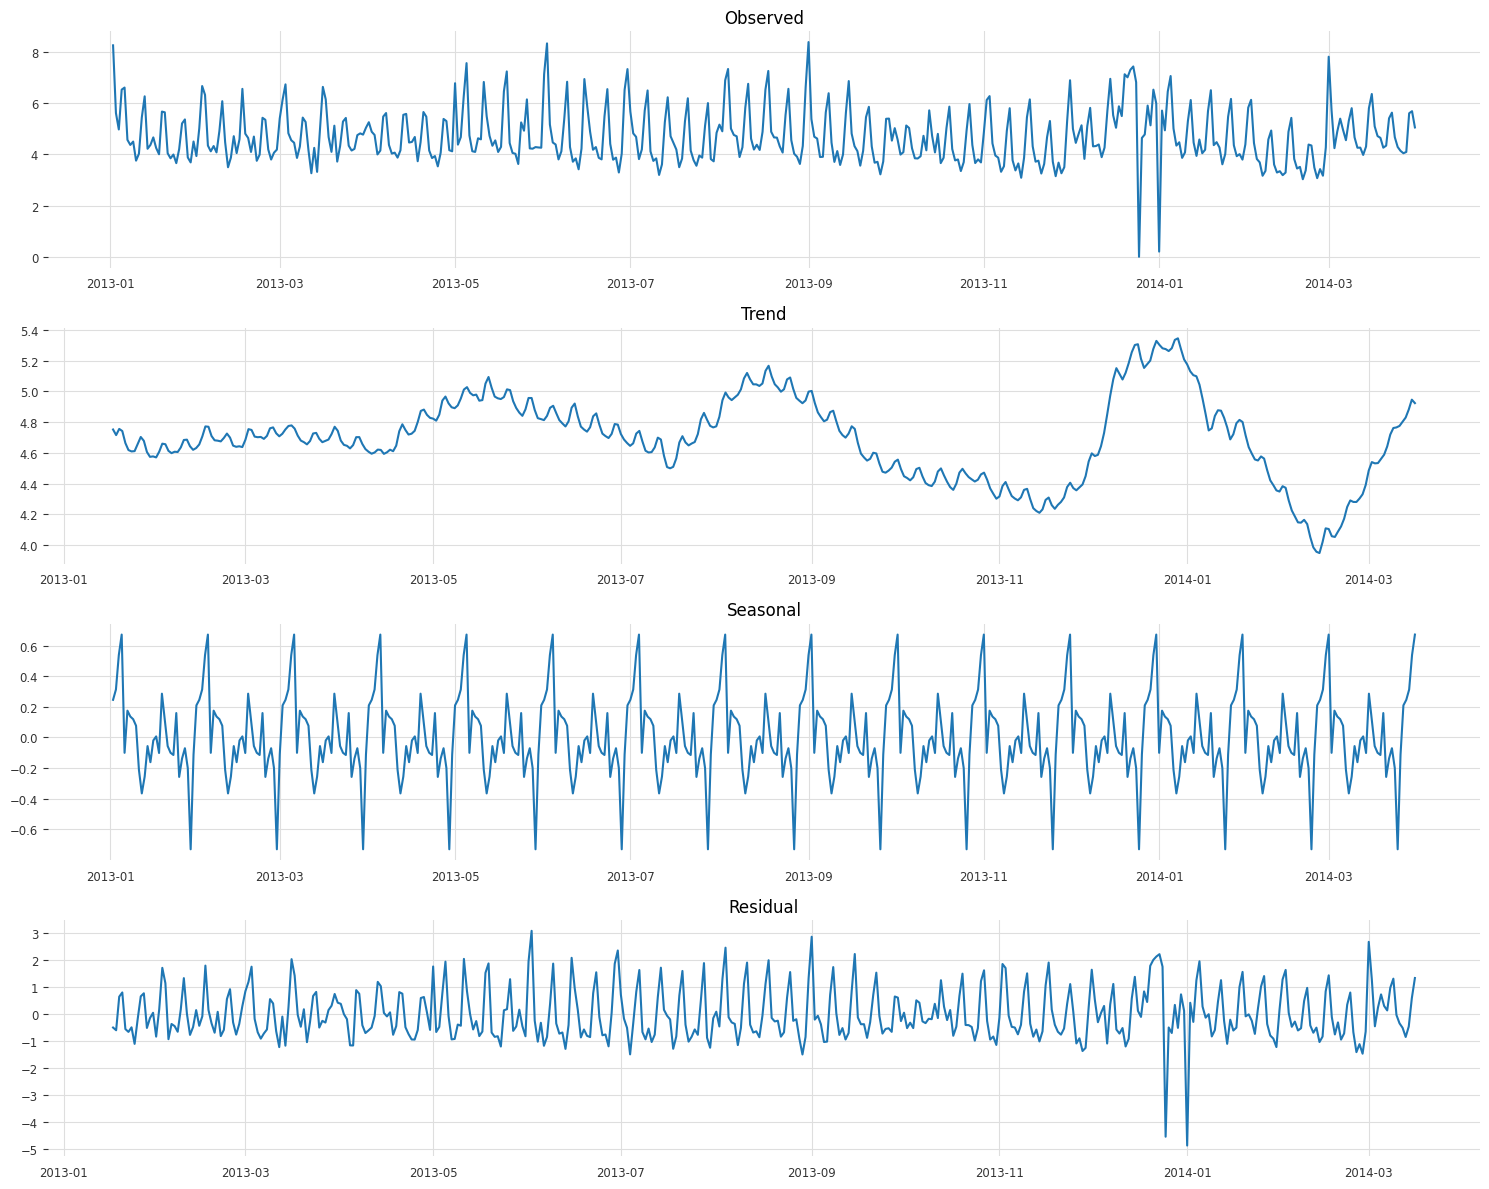

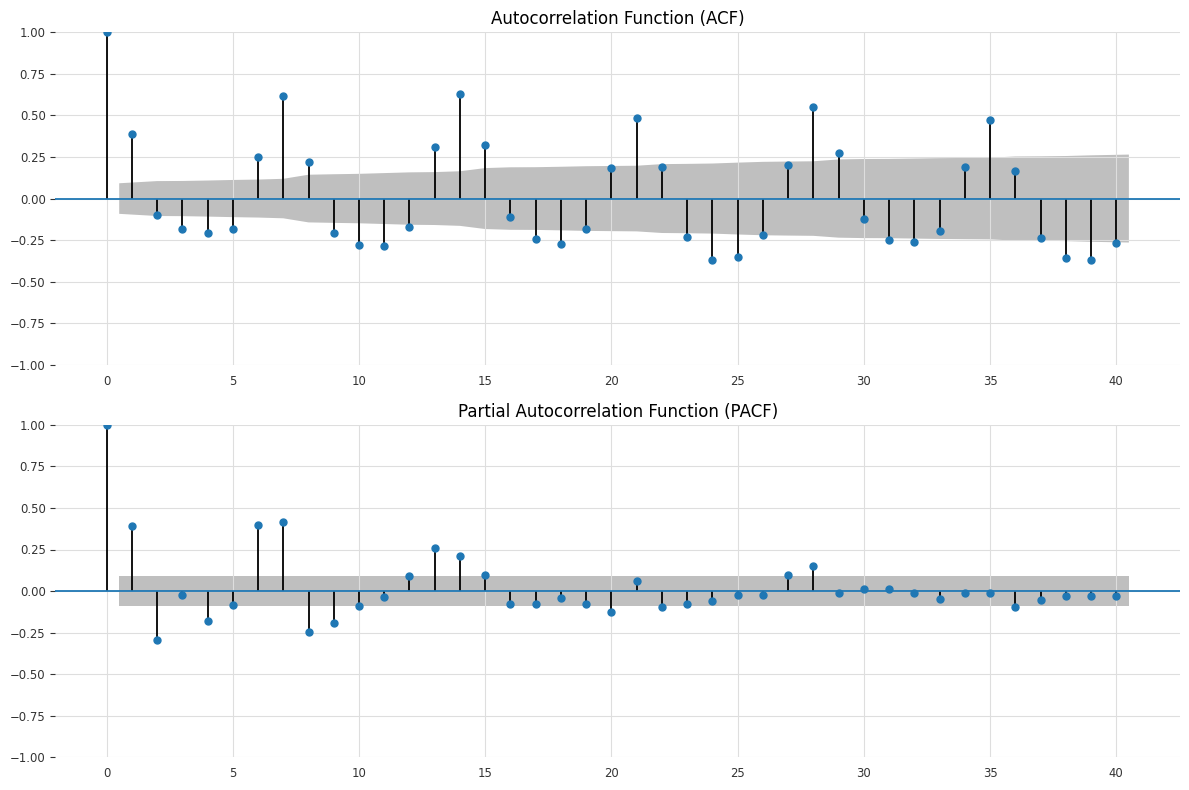

ADF Statistic: -3.582
p-value: 0.006
Critical Values:
   1%: -3.445
   5%: -2.868
   10%: -2.570


In [52]:
def decompose_time_series(df, period=30):
    print(f"\n=== TIME SERIES DECOMPOSITION ===")
    
    # Define blue colors
    blue_color = '#1f77b4'  # Default matplotlib blue
    light_blue = '#aec7e8'  # Lighter blue for variety
    
    df = df.set_index('date')['unit_sales']
    
    # Resample to daily frequency
    df = df.resample('D').mean().fillna(method='ffill')
    
    # Decompose time series
    decomposition = seasonal_decompose(df, period=period, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Observed component
    axes[0].plot(decomposition.observed, color=blue_color, linewidth=1.5)
    axes[0].set_title('Observed')
    
    # Trend component
    axes[1].plot(decomposition.trend, color=blue_color, linewidth=1.5)
    axes[1].set_title('Trend')
    
    # Seasonal component
    axes[2].plot(decomposition.seasonal, color=blue_color, linewidth=1.5)
    axes[2].set_title('Seasonal')
    
    # Residual component
    axes[3].plot(decomposition.resid, color=blue_color, linewidth=1.5)
    axes[3].set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # ACF and PACF plots for ARIMA parameter selection
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF plot with blue color
    plot_acf(df.dropna(), ax=axes[0], lags=40, color=blue_color)
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # PACF plot with blue color
    plot_pacf(df.dropna(), ax=axes[1], lags=40, color=blue_color)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity test
    result = adfuller(df.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

decompose_time_series(df_train)

Conclusion = The time series is stationary

The ADF statistic (-3.582) is more negative than all critical values:

It's lower than -3.445 (1% level)

It's lower than -2.868 (5% level)

It's lower than -2.570 (10% level)

The p-value (0.006) is less than 0.05 (and even less than 0.01), which means we can reject the null hypothesis of non-stationarity with high confidence.

Since the test statistic is more negative than the critical values at all significance levels, this provides strong evidence against the presence of a unit root.

### 4. ARIMA Model

In [53]:
# Group by date and aggregate sales for each day
series = df_train.groupby('date')['unit_sales'].sum().reset_index()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').sort_index()
series = series['unit_sales']

In [54]:
# Train-Test-Split
split_date = '2014-01-01'

train_1 = series[series.index < split_date]
test_1 = series[series.index >= split_date]

In [55]:
# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(train_1, order=(1,1,1))

# Fit the ARIMA model on the training data
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model_fit.forecast(steps=len(test_1))
arima_forecast.index = test_1.index  # align forecast with test dates

                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3815.231
Date:                Mon, 01 Sep 2025   AIC                           7636.461
Time:                        13:06:42   BIC                           7648.145
Sample:                    01-02-2013   HQIC                          7641.105
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4180      0.059      7.111      0.000       0.303       0.533
ma.L1         -0.9635      0.017    -56.816      0.000      -0.997      -0.930
sigma2      9.898e+07   4.23e-11   2.34e+18      0.0

/Users/lukasfichtner/Documents/Guayas_Project_week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/Guayas_Project_week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasfichtner/Documents/Guayas_Project_week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [56]:
# First check if this is computationally feasible
print(f"Test set size: {len(test_1)}")  # This is 1,003,891 - very large!

# If you really need to forecast this many steps, do it in chunks
def forecast_large_steps(model, steps, chunk_size=1000):
    forecasts = []
    remaining_steps = steps
    
    while remaining_steps > 0:
        current_steps = min(chunk_size, remaining_steps)
        forecast_chunk = model.forecast(steps=current_steps)
        forecasts.append(forecast_chunk)
        remaining_steps -= current_steps
    
    return pd.concat(forecasts)

# Forecast the full test set length
arima_forecast = forecast_large_steps(arima_model_fit, len(test_1))


Test set size: 90


R2 score: -0.05
Mean Absolute Error: 8908.83
AIC: 7636.46


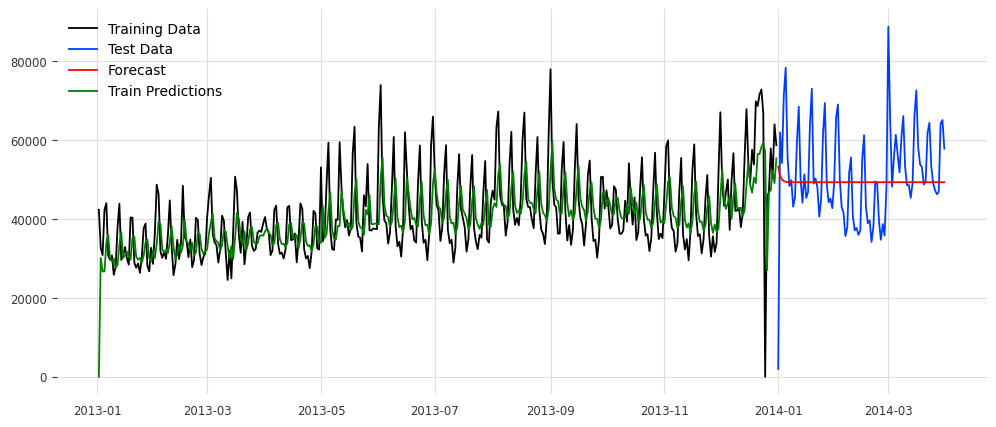

(date
 2014-01-01    53238.044644
 2014-01-02    50957.493938
 2014-01-03    50004.239892
 2014-01-04    49605.786450
 2014-01-05    49439.235733
                   ...     
 2014-03-27    49319.620314
 2014-03-28    49319.620314
 2014-03-29    49319.620314
 2014-03-30    49319.620314
 2014-03-31    49319.620314
 Name: predicted_mean, Length: 90, dtype: float64,
 -0.04864066266734257,
 8908.831933106916)

In [57]:
#Evaluates a fitted ARIMA model against a given test set

def model_evaluation(fit_result, train_1, test_1, exog=None):
  
    # In-sample predictions
    train_predictions = fit_result.fittedvalues

    # Forecast future values
    if exog is not None:
        forecast = fit_result.get_forecast(steps=len(test_1), exog=test_1[exog])
        test_predictions = forecast.predicted_mean
    else:
        test_predictions = fit_result.forecast(steps=len(test_1))
    
    # Align forecast index with test index
    test_predictions.index = test_1.index

    # Evaluation metrics
    mae = mean_absolute_error(test_1, test_predictions)
    r2 = r2_score(test_1, test_predictions)

    print(f'R2 score: {r2:1.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'AIC: {fit_result.aic:.2f}')

    # Plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(train_1, label='Training Data')
    ax.plot(test_1, label='Test Data')
    ax.plot(test_predictions, label='Forecast', color='red')
    ax.plot(train_predictions, label='Train Predictions', color='green')
    plt.legend()
    plt.show()

    return test_predictions, r2, mae

model_evaluation(arima_model_fit, train_1, test_1, exog=None)

- Based in the metrics, ARIMA ist completely unsuitable for this dataset. 
- XGBoost is the clearly superior choice